### Preprocessing of the CAMUS dataset

In [ ]:
# # Get the dataset from the drive and unzip it
# import zipfile
# zip_ref=zipfile.ZipFile('/content/drive/MyDrive/Medical_Imaging/LVEF/Datasets/CAMUS/Original/database-001.zip')
# zip_ref.extractall('/content/drive/MyDrive/Medical_Imaging/LVEF/Datasets/CAMUS/Original')
# zip_ref.close()


#### Import required libraries

In [45]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
import os
from os import path
import numpy as np 
import pandas as pd 
import time
from contextlib import contextmanager # timer
from functools import partial
import seaborn as sns
#To open the .mhd files(MetaImage MetaHeader files)
import SimpleITK as sitk
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
#Copy the files to preprocessed folder
import shutil

# import torch
# from torch.utils import data
# from torch.utils.data import DataLoader, Dataset

In [75]:
#To get the time taken for processing
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [76]:
img_size = 224

In [77]:
ROOT_PATH='/content/drive/MyDrive/Medical_Imaging/LVEF/Datasets/CAMUS/Original/database'
TRAIN_PATH=ROOT_PATH+'/training'
TEST_PATH=ROOT_PATH+'/testing'

In [78]:
# Z Normalize image by subtracting the mean and dividing by the standrad deviation
def data_norm(input):
    input = np.array(input, dtype=np.float32)
    input  = input - np.mean(input)
    #Add a very small value in denominator to prevent zero division
    output = input / (np.std(input) + 1e-12)
    return output

In [79]:
#Read the .mhd files 
def mhd_to_array(path):
    """
    Read a *.mhd file stored in path and return it as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(path, sitk.sitkFloat32))

In [80]:
#Read the .cfg file and return data as a dictionary
def read_info(data_file):
  info = {}
  with open( data_file, 'r' ) as f:
    for line in f.readlines():
      info_type, info_details = line.strip( '\n' ).split( ': ' )
      info[ info_type ] = info_details
  return info

(1, 1167, 748)


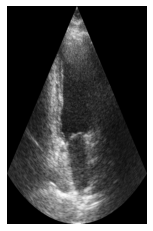

In [81]:
#Visualize a single .mhd image
file='/content/drive/MyDrive/Medical_Imaging/LVEF/Datasets/CAMUS/Original/database/training/patient0002/patient0002_2CH_ED.mhd'
itk_image = sitk.ReadImage(file)
image_array = sitk.GetArrayViewFromImage(itk_image)
# print the image's dimensions
print(image_array.shape)
# plot the image
plt.axis('off')
plt.imshow(image_array[0], cmap='gray')
plt.show()

In [82]:
#Define dictionaries to store the images and gt files for 2C and 4C files for train and test images
train_files,test_files={},{}

In [83]:
#Function to read the .mhd and _gt.mhd file paths for 2C and 4C and store in seperate dictionaries
def load_data_path(dir_path):
  #Define lists to read the eds and es files for 2C and 4C
  a2c_ims, a2c_gts,a2c_seq, a2c_info = [], [],[],[]
  a4c_ims, a4c_gts,a4c_seq, a4c_info = [], [],[],[]
  #Iterate through each patient directory
  for p_dir in os.listdir(dir_path):
      p_dir_path = dir_path + '/' + p_dir
      #Check if it is a folder
      if os.path.isdir(p_dir_path):
        #Iterate through each file in a patient directory
        for file in os.listdir(p_dir_path):
            file_path = p_dir_path + '/' + file
            #Get path of the .mhd files
            if file.split('.')[1] == 'mhd':
              # find 2C files for ED,ES
              if file.split('.')[0].split('_')[1] == '2CH':
                # find gt files
                if file.split('.')[0].split('_')[-1] == 'gt':  
                  a2c_gts.append(p_dir+ '/' + file)
                #find sequence files
                elif file.split('.')[0].split('_')[-1] == 'sequence':  
                  a2c_seq.append(p_dir+ '/' + file)
                #Add all remaining .mhd files
                else: 
                  a2c_ims.append(p_dir+ '/' + file)
              # find 4C files for ED,ES
              elif file.split('.')[0].split('_')[1] == '4CH':
                # find gt files
                if file.split('.')[0].split('_')[-1] == 'gt':  
                  a4c_gts.append(p_dir+ '/' + file)
                #find sequence files
                elif file.split('.')[0].split('_')[-1] == 'sequence':  
                  a4c_seq.append(p_dir+ '/' + file)
                #Add all remaining .mhd files
                else: 
                  a4c_ims.append(p_dir+ '/' + file)
            #Get path of the .cfg files
            elif file.split('.')[1] == 'cfg': 
              if file.split('.')[0].split('_')[-1] == '2CH':
                a2c_info.append(p_dir+ '/' + file)
              elif file.split('.')[0].split('_')[-1] == '4CH':
                a4c_info.append(p_dir+ '/' + file)

  #Add the dictionary to the parent dictionary for img and gt files
  seq_2ch_files,ims_2ch_files,info_2ch_files,gt_2ch_files={},{},{},{}
  seq_2ch_files.update({'sequences':a2c_seq})
  ims_2ch_files.update({'frames':a2c_ims})
  info_2ch_files.update({'info':a2c_info})
  gt_2ch_files.update({'masks':a2c_gts})

  seq_4ch_files,ims_4ch_files,info_4ch_files,gt_4ch_files={},{},{},{}
  seq_4ch_files.update({'sequences':a4c_seq})
  ims_4ch_files.update({'frames':a4c_ims})
  info_4ch_files.update({'info':a4c_info})
  gt_4ch_files.update({'masks':a4c_gts})

  #Define a list to add the above dictionaries
  files_2ch_lst=[]
  files_2ch_lst.append(seq_2ch_files)
  files_2ch_lst.append(ims_2ch_files)
  files_2ch_lst.append(info_2ch_files)
  files_2ch_lst.append(gt_2ch_files)

  files_4ch_lst=[]
  files_4ch_lst.append(seq_4ch_files)
  files_4ch_lst.append(ims_4ch_files)
  files_4ch_lst.append(info_4ch_files)
  files_4ch_lst.append(gt_4ch_files)

  files_lst={}
  files_lst.update({'2C':files_2ch_lst})
  files_lst.update({'4C':files_4ch_lst})

  return files_lst

In [84]:
#Load the file paths for 2C and 4C files for train and test
train_files=load_data_path(TRAIN_PATH)
test_files=load_data_path(TEST_PATH)


### Save the images in the corresponding folders

In [85]:
SAVE_PATH=ROOT_PATH+'/Preprocessed'

In [86]:
#Check if the save path exists else create the required folders
if not path.exists(SAVE_PATH):
  os.mkdir(SAVE_PATH)
  sub_lst1=['training','testing']
  sub_lst2=['2C','4C']
  sub_lst3=['sequences','frames','info','masks']

  for i in sub_lst1:
    for j in sub_lst2:
      for k in sub_lst3:
       os.makedirs(SAVE_PATH+'/'+i+'/'+j+'/'+k)

In [87]:
#Iterate through the imagepath list and save the images in the corresponding folder
def save_Images(filePathLst,c,trainortest):
  new_path=SAVE_PATH+'/'+trainortest+'/'+c+'/'
  for filedict in filePathLst:
    for folder,filepath in filedict.items():
      for file in filepath:
        #Check for the .cfg file nd rename it since all patients have same .cfg file name
        if file.split('.')[1] == 'cfg':
          #patientid_filename.cfg
          img_name=file.split('/')[0]+'_'+file.split('/')[-1]
        else:
          #for the .mhd files
          img_name=file.split('/')[-1]
        src_path=TRAIN_PATH+'/'+file
        dst_path = new_path+folder+'/'+img_name
        #Copy file to the required folder
        shutil.copy(src_path, dst_path)       

In [88]:
#Saving the images in 2C and 4C folders for train files
for c,pathlist in train_files.items():
  save_Images(pathlist,c,'training')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [89]:
#Saving the images in 2C and 4C folders for test files
for c,pathlist in test_files.items():
  save_Images(pathlist,c,'testing')